# Jigsaw Toxic Comment Classification: Deep Learning

Team 1: Jiashu Chen, Qianqian Liu, Irene Yang, Chesie Yu

6/1/2023

<style type = "text/css">  
    body {
        font-family: "Serif"; 
        font-size: 12pt;
    }
    em {
        color: #4E7F9E;
    }
    strong {
        color: #436D87;
    }
    .jp-RenderedHTMLCommon a:link { 
        color: #94C1C9;
    }
    .jp-RenderedHTMLCommon a:visited { 
        color: #94C1C9;
    }
    li {
        color: #4E7F9E;
    }
    .jp-RenderedHTMLCommon code {
        color: #4E7F9E;
    }  
    img {
        display: block;
        margin: auto;
    } 
</style>

## I. Data

_This study uses the **Jigsaw toxic comment data** from [Kaggle](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data). Our training corpus consists of **over 150,000 Wikipedia comments**, pre-labeled to identify **6 subtypes of toxic behavior**._

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the data 
train = pd.read_csv("data/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Check the dimensions
print(f"Number of rows: {train.shape[0]}\n"
      f"Number of columns: {train.shape[1]}")

# Check for missing values
print(f"Number of missing values: {train.isna().sum().sum()}")

Number of rows: 159571
Number of columns: 8
Number of missing values: 0


In [6]:
# Inspect the classes
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
classes = [train[col].value_counts(normalize=True) for col in cols]
pd.DataFrame(classes, index=cols)

,0,1
toxic,0.904156,0.095844
severe_toxic,0.990004,0.009996
obscene,0.947052,0.052948
threat,0.997004,0.002996
insult,0.950636,0.049364
identity_hate,0.991195,0.008805


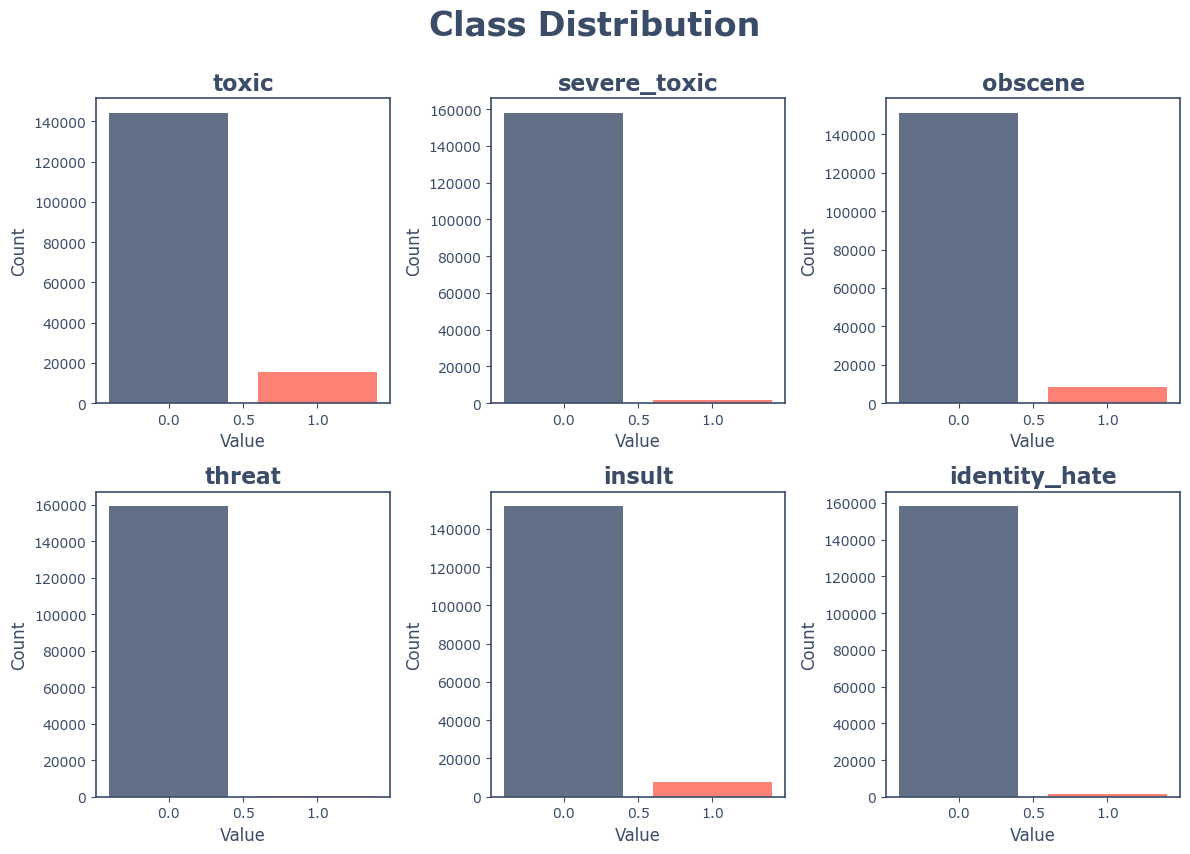

In [7]:
# Set up the figure with subplots
plt.rcParams.update({"font.family": "Verdana"})
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8.5))

# Visualize the class distribution for each column
for i, col in enumerate(cols):
    counts = train[col].value_counts()
    axs[i // 3, i % 3].bar(counts.index, counts.values, color=["#617086", "#FE8175"])
    axs[i // 3, i % 3].set_title(col, size=16, color="#3A4C68", weight="bold")
    axs[i // 3, i % 3].set_xlabel("Value", size=12, color="#3A4C68")
    axs[i // 3, i % 3].set_ylabel("Count", size=12, color="#3A4C68")
    axs[i // 3, i % 3].tick_params(axis="x", colors="#3A4C68")
    axs[i // 3, i % 3].tick_params(axis="y", colors="#3A4C68")
    # Change border color 
    for spine in axs[i // 3, i % 3].spines.values():
        spine.set_edgecolor("#3A4C68")
        spine.set_linewidth(1.2)

# Display the plot
fig.suptitle("Class Distribution", size=24, color="#3A4C68", weight="bold", y=1) # Assign main title
fig.tight_layout()

___

## II. Data Processing

### 2.1 Train-Dev-Test Split

_We first performed **train-dev-test split** to **avoid overfiting**. Separate training and test sets were acquired from Kaggle. We allocated **20%** of the initial training data to create a **development set** for **hyperparameter tuning and model selection**. The **test set** provided a final **unbiased evaluation** of model performance._

In [18]:
# Import the library
from sklearn.model_selection import train_test_split

In [19]:
# Perform train-dev split
X_train, X_dev, y_train, y_dev = train_test_split(train["comment_text"], train[cols], 
                                                  test_size=0.2, random_state=10)

In [20]:
# Reshape the data
X_train = np.array(X_train).reshape(X_train.shape[0], 1)
X_dev = np.array(X_dev).reshape(X_dev.shape[0], 1)

print(X_train.shape, X_dev.shape, y_train.shape, y_dev.shape)

(127656, 1) (31915, 1) (127656, 6) (31915, 6)


### 2.2 Text Preprocessing

_To preserve the **most relevant information** for analysis, we implemented several preprocessing steps: **tab and space removal, lowercase conversion, non-alphabets removal, POS tagging and lemmatization, and stopword removal**. Lemmatization was selected over stemming to avoid "over-stemming" problems, which reduced words to non-standard forms._

In [27]:
# nltk.download("averaged_perceptron_tagger")
# nltk.download("wordnet")
# nltk.download("stopwords")

In [29]:
# Import the libraries
import re

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [30]:
# Need to convert treebank_tag to wordnet tag before lemmatization
# reference code: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
def get_wordnet_pos(treebank_tag):
    """
    Convert Treebank POS tags to WordNet POS tags.
    """
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [31]:
def postag_lemmatize(t):
    """
    Perform lemmatization on a list of tokens using their POS tags.
    """
    # Empty list to store lemmatized  tokens
    l = []
    
    # Perform POS tagging using Penn Treebank tagger
    tagged_t = nltk.pos_tag(t)
    
    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Perform lemmatization
    for word, tag in tagged_t:
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            l.append(lemmatizer.lemmatize(word))
        else:
            l.append(lemmatizer.lemmatize(word, pos=wntag))
    return l 

In [32]:
def text_clean(t):
    """
    Preprocess a text string.
    """
    # Remove new lines and tabs
    t = re.sub(r"[\n\t]", " ", t)
    
    # Convert to lowercase
    t = t.lower()
    
    # Remove non-alphabetic characters
    t = re.sub("[^a-z]", " ", t)
    
    # Split text into tokens
    t = t.split()
    
    # Lemmatize the tokens
    t = postag_lemmatize(t)
    
    # Remove stopwords
    t = [w for w in t if w not in set(stopwords.words("english"))]
    return t

In [33]:
# Size of vocabulary (number of rows in embedding matrix)
max_features = 20000 

# Max length of sequence (number of words in a comment)
maxlen = 50 

# Size of word embeddings (each word will be represented a 100-dimension vector)
embed_size = 100

In [34]:
# Convert training and validation data into a list of strings
comment_list_train = [str(item[0]) for item in X_train.tolist()]
comment_list_dev = [str(item[0]) for item in X_dev.tolist()]

In [35]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comment_list_train)

In [36]:
# Convert text to sequences of integers
tokens_train = tokenizer.texts_to_sequences(comment_list_train)
tokens_dev = tokenizer.texts_to_sequences(comment_list_dev)

In [37]:
# Pad the sequences so that they all have the same length
tokens_train = pad_sequences(tokens_train, maxlen=maxlen)
tokens_dev = pad_sequences(tokens_dev, maxlen=maxlen)

In [38]:
# Retrieve the word index
word_index = tokenizer.word_index

In [39]:
print(tokens_train.shape, tokens_dev.shape)

(127656, 50) (31915, 50)


### 2.3 GloVe Embeddings

_Using Keras tokenizer, we extracted **20,000 unique words** from our preprocessed text based on frequency and assigned each word a unique index. Subsequently, we downloaded the **GloVe word embeddings** and extracted the **100-dimensional word embeddings** for each word. This allowed us to create a **20,000 * 100 embedding matrix**, which was **normalized** and used as the **embedding layer**, the first layer in all our neural network models._  

In [48]:
def build_word_dict(d, file):
    """
    Build a dictionary from a word embedding file
    """
    with open(file, "r") as f:
        for line in f.readlines(): # Read the file line by line
            line = line.split(" ") # Split each line by space

            try:
                # line[0] represents the word, the key of the dictionary
                # line[1:] are embeddings, the value of the dictionary
                d[line[0]] = np.array(line[1:], dtype="float32")    
            except: 
                continue

In [50]:
# Build the embedding dictionary
embeddings_dict = dict()
build_word_dict(embeddings_dict, "data/glove.6B.100d.txt")

In [51]:
# Normalize the embeddings
embed_vals = np.stack(list(embeddings_dict.values()))
embed_mean, embed_std = embed_vals.mean(), embed_vals.std()
print(embed_mean, embed_std)

0.004451992 0.4081574


In [52]:
# Create the embedding matrix
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

# Initialize the embedding matrix with random values from a normal distribution
embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words, embed_size))

# Populate the embedding matrix with GloVe embeddings
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

___

## III. Experiments

### 3.0 Performance Evaluation Utility Functions

_Commonly used evaluation metrics such as accuracy are misleading for **imbalanced data**. To **avoid over-optimistic assessments**, we adopt a more robust evaluation approach that incorporates precision, recall, and F1 score. Precision and recall inform decision-making in targeted aspects: low precision restricts information access and free speech by systematically flagging harmless comments; low recall leads to proliferation of toxic hubs due to inability to capture toxicity. To strike the **balance** between the two, we therefore prioritize **F1 score**, the harmonic mean, as the key metric. We hope to achieve the **optimal equilibrium** between freedom of speech and safe online environment for users._

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras import backend as K

In [59]:
def float_array_to_binary(float_array, threshold):
    """
    Convert float arrays to binary based on specified threshold.
    """
    binary_array = np.where(np.array(float_array) >=  threshold, 1, 0)
    return binary_array

In [60]:
def chooseThreshold(subtype, true, pred, plot = True):
    """
    Choose the optimal threshold for binary classification.
    """
    max_f1 = 0
    argmax_f1 = 0
    accuracy_list = []
    recall_list = []
    precision_list = []
    f1_list = []
    thres_list = np.arange(0.1, 1.0, 0.1)

    # Iterate over each threshold to compute performance metrics
    for i in thres_list:
        i = round(i, 2)
        pred_i = float_array_to_binary(pred, i)
        accuracy = accuracy_score(true, pred_i)
        accuracy_list.append(accuracy)
        recall = recall_score(true, pred_i)
        recall_list.append(recall)
        precision = precision_score(true, pred_i)
        precision_list.append(precision)
        f1 = f1_score(true, pred_i)
        f1_list.append(f1)
        if f1 > max_f1:
            max_f1 = f1
            argmax_f1 = i
    
    if plot:
        plt.plot(thres_list, accuracy_list, label ="accuracy")
        plt.plot(thres_list, recall_list, "-.", label ="recall")
        plt.plot(thres_list, precision_list, "-", label ="precision")
        plt.plot(thres_list, f1_list, ":", label ="f1")
        plt.plot(argmax_f1, max_f1,"bo-")
        label = "(" + str(argmax_f1) + ", " + str(round(max_f1,2)) + ")"
        plt.annotate(label, (argmax_f1, max_f1), textcoords="offset points",
                        xytext=(0,10), ha="center") 

        plt.xlabel("threshold")
        plt.ylabel("performance")
        plt.legend()
        plt.title(subtype + " Subtype : Performance At Different Threshold")
        plt.show()
    return argmax_f1, max_f1

In [61]:
def metrics(pred, true):
    """
    Calculates the classification metrics. 
    """
    conf_matrix = confusion_matrix(true, pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    return round(accuracy,4), round(precision,4), round(recall,4), round(f1,4)

In [62]:
def Model_OverallPerformance(y_pred, y_true, adjustThreshold=True, Thresholdplot=False):
    """
    Evaluate model performance across 6 toxicity subtypes.
    """
    # Extract true labels for each toxicity subtype
    y_true_toxic = [row[0] for row in y_true]
    y_true_severe_toxic = [row[1] for row in y_true]
    y_true_obscene  = [row[2] for row in y_true]
    y_true_threat = [row[3] for row in y_true]
    y_true_insult = [row[4] for row in y_true]
    y_true_identity_threat = [row[5] for row in y_true]

    # Extract predicted labels for each toxicity subtype
    y_pred_toxic = [row[0] for row in y_pred]
    y_pred_severe_toxic = [row[1] for row in y_pred]
    y_pred_obscene  = [row[2] for row in y_pred]
    y_pred_threat = [row[3] for row in y_pred]
    y_pred_insult = [row[4] for row in y_pred]
    y_pred_identity_threat = [row[5] for row in y_pred]

    # If True, optimize the threshold for each subtype to maximize F1 score
    if adjustThreshold:
        thresh_toxic, f1_toxic = chooseThreshold("Toxic", y_true_toxic, y_pred_toxic, Thresholdplot)
        thresh_severe_toxic, f1_severe_toxic = chooseThreshold("Severe Toxic", y_true_severe_toxic, y_pred_severe_toxic, Thresholdplot)
        thresh_obscene, f1_obscene = chooseThreshold("Obsence", y_true_obscene, y_pred_obscene, Thresholdplot)
        thresh_threat, f1_threat = chooseThreshold("Threat", y_true_threat, y_pred_threat, Thresholdplot)
        thresh_insult, f1_insult = chooseThreshold("Insult", y_true_insult, y_pred_insult, Thresholdplot)
        thresh_identity_threat, f1_identity_threat = chooseThreshold("Identity Threat", y_true_identity_threat, y_pred_identity_threat, Thresholdplot)

        # Convert predicted probabilities to binary classification
        y_pred_toxic = float_array_to_binary(y_pred_toxic, thresh_toxic)
        y_pred_severe_toxic = float_array_to_binary(y_pred_severe_toxic, thresh_severe_toxic)
        y_pred_obscene = float_array_to_binary(y_pred_obscene, thresh_obscene)
        y_pred_threat = float_array_to_binary(y_pred_threat, thresh_threat)
        y_pred_insult = float_array_to_binary(y_pred_insult, thresh_insult)
        y_pred_identity_threat = float_array_to_binary(y_pred_identity_threat, thresh_identity_threat)

    # Compute accuracy, precision, recall, and F1 score for each subtype
    accuracy_toxic, precision_toxic, recall_toxic, f1_toxic = metrics(y_pred_toxic, y_true_toxic)
    accuracy_severe_toxic, precision_severe_toxic, recall_severe_toxic, f1_severe_toxic = metrics(y_pred_severe_toxic, y_true_severe_toxic)
    accuracy_obscene, precision_obscene, recall_obscene, f1_obscene = metrics(y_pred_obscene, y_true_obscene)
    accuracy_threat, precision_threat, recall_threat, f1_threat = metrics(y_pred_threat, y_true_threat)
    accuracy_insult, precision_insult, recall_insult, f1_insult = metrics(y_pred_insult, y_true_insult)
    accuracy_identity_threat, precision_identity_threat, recall_identity_threat, f1_identity_threat = metrics(y_pred_identity_threat, y_true_identity_threat)

    # Store as lists
    accuracy_list = [accuracy_toxic, accuracy_severe_toxic, accuracy_obscene, accuracy_threat,accuracy_insult, accuracy_identity_threat]
    precision_list = [precision_toxic, precision_severe_toxic, precision_obscene, precision_threat,precision_insult, precision_identity_threat]
    recall_list = [ recall_toxic,  recall_severe_toxic,  recall_obscene,  recall_threat, recall_insult,  recall_identity_threat]
    f1_list = [f1_toxic, f1_severe_toxic, f1_obscene, f1_threat,f1_insult, f1_identity_threat]

    subtypes = ["Toxic", "Severe_Toxic", "Obscene", "Threat", "Insult", "Identity_Hate"]
    metric = ["Accuracy", "Precision", "Recall", "F1"]
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(
    data = [accuracy_list, precision_list, recall_list, f1_list],
    columns = subtypes,
    index = metric
    )
    print("\n")
    display(metrics_df)

    # Plot the performance metrics for each subtype
    print("\n")
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics_df.plot(kind="bar", rot=0, ax=ax, width=0.8, cmap="RdBu")
    for i, j in enumerate(ax.patches):
        ax.text(j.get_x() + j.get_width() / 2, j.get_height() + 0.01,
                str(round(j.get_height(), 2)), ha="center")
    plt.xlabel("Metrics")
    plt.ylabel("Scores")
    plt.title("Performance Metrics by Toxicity Type")
    plt.tight_layout()
    plt.show()

In [63]:
def recall_m(y_true, y_pred):
    """
    Compute recall in a Keras-compatible way. 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    """
    Compute precision in a Keras-compatible way. 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    """
    Compute F1 score in a Keras-compatible way. 
    """
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

_Using a **comparative setting**, we examine the performance of different neural network architectures on identical training, dev, and test sets in Google Colab. Each proposed model incorporates **100-dimensional embeddings as input** and features a **6-unit dense layer with sigmoid activation for output**. To account for class imbalance, we **adjust the decision threshold** for each subtype to optimize the F1 score, instead of using the default binary classification threshold 0.5. Models are validated on the dev set to determine the best-performing model in each category; hyperparameter tuning is performed using Keras random search tuner. Final evaluation of model effectiveness is carried out using the test set, consisting of 63,978 comments._

_Following this framework, we conduct six experiments as follows: **DNN, CNN, CNN + LSTM, 1-Layer BLSTM, 2-Layer BLSTM, 3-Layer BLSTM**._

In [66]:
# Import the libraries
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, Sequential, load_model

### 3.1 Experiment 1: DNN

_Model 1 uses an embedding layer followed by global max pooling to reduce the sequence length, which is then fed into **a series of dense layers** with batch normalization and dropout for regularization.  This **simple architecture** allows for **faster training**, yet may **struggle with capturing complex dependencies in text data** as seen below._    

In [69]:
# Build the model
model_1 = Sequential([])
model_1.add(layers.Input(shape=(maxlen, )))
model_1.add(layers.Embedding(embedding_matrix.shape[0],
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix]))
model_1.add(layers.GlobalMaxPooling1D())
model_1.add(layers.Dense(32, activation="relu"))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dropout(0.1))
model_1.add(layers.Dense(16, activation="relu"))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dropout(0.1))
model_1.add(layers.Dense(6, activation="sigmoid"))

model_1.summary()

2024-08-30 22:30:00.436996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-30 22:30:00.437037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2000000   
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)      

In [64]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=[f1_m])

# Model checkpoint
checkpoint = ModelCheckpoint("models/model-01-dnn.tf", 
                             monitor="val_f1_m", 
                             save_best_only=True,
                             mode="max")

# Early stopping
early_stopping = EarlyStopping(monitor="val_f1_m", 
                               patience=3, 
                               mode="max", 
                               restore_best_weights=True)

# Learning rate scheduler (optional)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", 
                                 factor=0.5, 
                                 patience=2, 
                                 min_lr=1e-6)

# Fit the model
model_1.fit(tokens_train, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/10


2024-08-30 09:45:48.215663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3192/3192 [==============================] - ETA: 0s - loss: 0.1312 - f1_m: 0.4284

2024-08-30 09:46:41.869205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


3192/3192 [==============================] - 58s 18ms/step - loss: 0.1312 - f1_m: 0.4284 - val_loss: 0.0644 - val_f1_m: 0.5431 - lr: 0.0010
Epoch 2/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0605 - f1_m: 0.6045INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


3192/3192 [==============================] - 50s 16ms/step - loss: 0.0605 - f1_m: 0.6045 - val_loss: 0.0589 - val_f1_m: 0.6157 - lr: 0.0010
Epoch 3/10
3192/3192 [==============================] - 49s 15ms/step - loss: 0.0515 - f1_m: 0.6532 - val_loss: 0.0586 - val_f1_m: 0.5792 - lr: 0.0010
Epoch 4/10
3191/3192 [============================>.] - ETA: 0s - loss: 0.0457 - f1_m: 0.6857INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


3192/3192 [==============================] - 53s 17ms/step - loss: 0.0457 - f1_m: 0.6855 - val_loss: 0.0571 - val_f1_m: 0.6180 - lr: 0.0010
Epoch 5/10
3192/3192 [==============================] - 60s 19ms/step - loss: 0.0407 - f1_m: 0.7192 - val_loss: 0.0627 - val_f1_m: 0.6011 - lr: 0.0010
Epoch 6/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0370 - f1_m: 0.7400INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


INFO:tensorflow:Assets written to: models/model-01-dnn.tf/assets


3192/3192 [==============================] - 45s 14ms/step - loss: 0.0370 - f1_m: 0.7400 - val_loss: 0.0616 - val_f1_m: 0.6387 - lr: 0.0010
Epoch 7/10
3192/3192 [==============================] - 75s 24ms/step - loss: 0.0330 - f1_m: 0.7692 - val_loss: 0.0647 - val_f1_m: 0.6208 - lr: 5.0000e-04
Epoch 8/10
3192/3192 [==============================] - 79s 25ms/step - loss: 0.0308 - f1_m: 0.7900 - val_loss: 0.0657 - val_f1_m: 0.6326 - lr: 5.0000e-04
Epoch 9/10
3192/3192 [==============================] - 79s 25ms/step - loss: 0.0289 - f1_m: 0.7967 - val_loss: 0.0700 - val_f1_m: 0.6268 - lr: 2.5000e-04


In [75]:
# Load the best model
model_1 = load_model("models/model-01-dnn.tf", custom_objects={"f1_m": f1_m})

17/32 [==============>...............] - ETA: 0s

2024-08-30 22:30:01.408620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step




,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9545,0.9867,0.9793,0.9946,0.9680,0.9915
Precision,0.8019,0.3822,0.8446,0.3279,0.6509,0.5083
Recall,0.6866,0.5929,0.7406,0.5505,0.7476,0.4473
F1,0.7398,0.4648,0.7892,0.4110,0.6959,0.4758


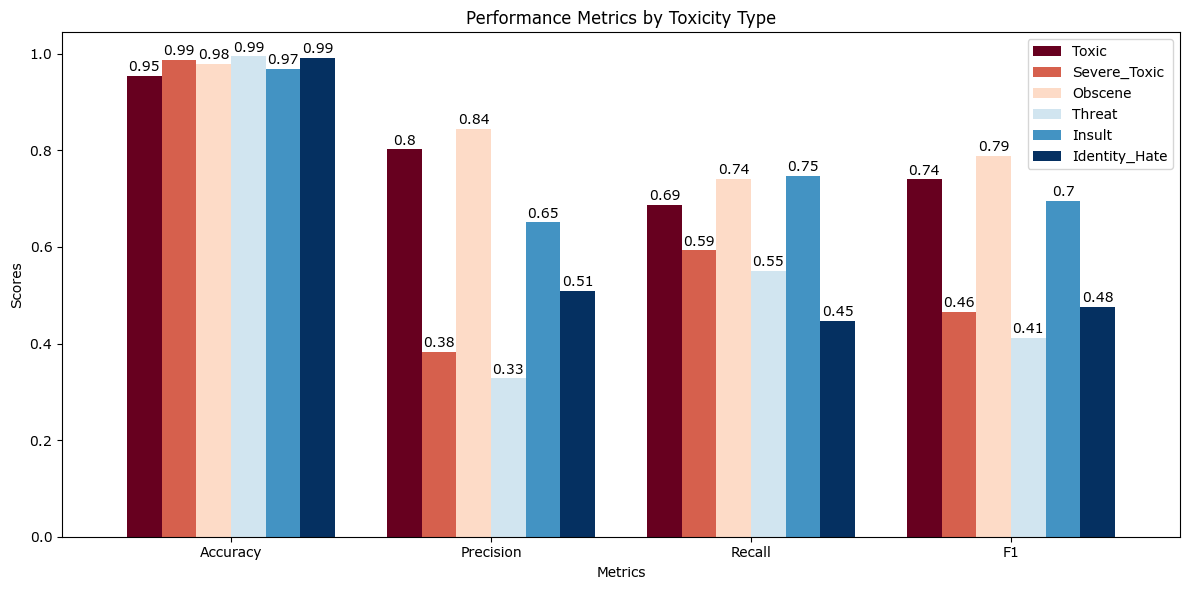

In [76]:
# Make predictions
y_pred = model_1.predict([tokens_dev], batch_size=1024, verbose=1)

# Evaluate the performance
Model_OverallPerformance(y_pred, y_dev.values, adjustThreshold=True, Thresholdplot=False)

_The **DNN** model showed **moderate performance** across all toxicity subtypes; however, it generally **underperformed** compared to the more complex CNN and LSTM-based models below._  

### 3.2 Experiment 2: CNN

_Model 2 incorporates a **convolutional layer**, allowing the model to **capture local patterns** (e.g., n-grams) in the text, followed by dense layers for classification.  While this improves feature extraction from text, it still lacks the ability to capture long-range dependencies like LSTM._  

In [77]:
# Build the model
model_2 = Sequential([])

model_2.add(layers.Input(shape=(maxlen,)))
model_2.add(layers.Embedding(embedding_matrix.shape[0],
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix]))
model_2.add(layers.Conv1D(128, 3, activation="relu"))
model_2.add(layers.GlobalMaxPool1D())
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(50, activation="relu"))
model_2.add(layers.Dropout(0.1))
model_2.add(layers.Dense(6, activation="sigmoid"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 48, 128)           38528     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [76]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=[f1_m])

# Model checkpoint
checkpoint = ModelCheckpoint("models/model-02-cnn.tf", 
                             monitor="val_f1_m", 
                             save_best_only=True,
                             mode="max")

# Early stopping
early_stopping = EarlyStopping(monitor="val_f1_m", 
                               patience=3, 
                               mode="max", 
                               restore_best_weights=True)

# Learning rate scheduler (optional)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", 
                                 factor=0.5, 
                                 patience=2, 
                                 min_lr=1e-6)

# Fit the model
model_2.fit(tokens_train, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/10


2024-08-30 10:01:18.747171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3192/3192 [==============================] - ETA: 0s - loss: 0.0666 - f1_m: 0.5551

2024-08-30 10:02:01.028378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


3192/3192 [==============================] - 46s 14ms/step - loss: 0.0666 - f1_m: 0.5551 - val_loss: 0.0530 - val_f1_m: 0.6369 - lr: 0.0010
Epoch 2/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0480 - f1_m: 0.6564INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


3192/3192 [==============================] - 36s 11ms/step - loss: 0.0480 - f1_m: 0.6564 - val_loss: 0.0510 - val_f1_m: 0.6441 - lr: 0.0010
Epoch 3/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0412 - f1_m: 0.6918INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


3192/3192 [==============================] - 37s 11ms/step - loss: 0.0412 - f1_m: 0.6918 - val_loss: 0.0519 - val_f1_m: 0.6612 - lr: 0.0010
Epoch 4/10
3192/3192 [==============================] - 35s 11ms/step - loss: 0.0362 - f1_m: 0.7238 - val_loss: 0.0541 - val_f1_m: 0.6579 - lr: 0.0010
Epoch 5/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0286 - f1_m: 0.7764INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


INFO:tensorflow:Assets written to: models/model-02-cnn.tf/assets


3192/3192 [==============================] - 37s 12ms/step - loss: 0.0286 - f1_m: 0.7764 - val_loss: 0.0587 - val_f1_m: 0.6615 - lr: 5.0000e-04
Epoch 6/10
3192/3192 [==============================] - 38s 12ms/step - loss: 0.0249 - f1_m: 0.8041 - val_loss: 0.0629 - val_f1_m: 0.6601 - lr: 5.0000e-04
Epoch 7/10
3192/3192 [==============================] - 37s 12ms/step - loss: 0.0205 - f1_m: 0.8313 - val_loss: 0.0700 - val_f1_m: 0.6589 - lr: 2.5000e-04
Epoch 8/10
3192/3192 [==============================] - 38s 12ms/step - loss: 0.0184 - f1_m: 0.8570 - val_loss: 0.0783 - val_f1_m: 0.6460 - lr: 2.5000e-04


In [79]:
# Load the best model
model_2 = load_model("models/model-02-cnn.tf", custom_objects={"f1_m": f1_m})

14/32 [============>.................] - ETA: 0s

2024-08-30 22:30:05.204830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9580,0.9880,0.9793,0.9963,0.9714,0.9898
Precision,0.7984,0.4175,0.8139,0.4643,0.6837,0.4350
Recall,0.7405,0.5673,0.7842,0.4771,0.7713,0.5964
F1,0.7684,0.4810,0.7988,0.4706,0.7249,0.5031


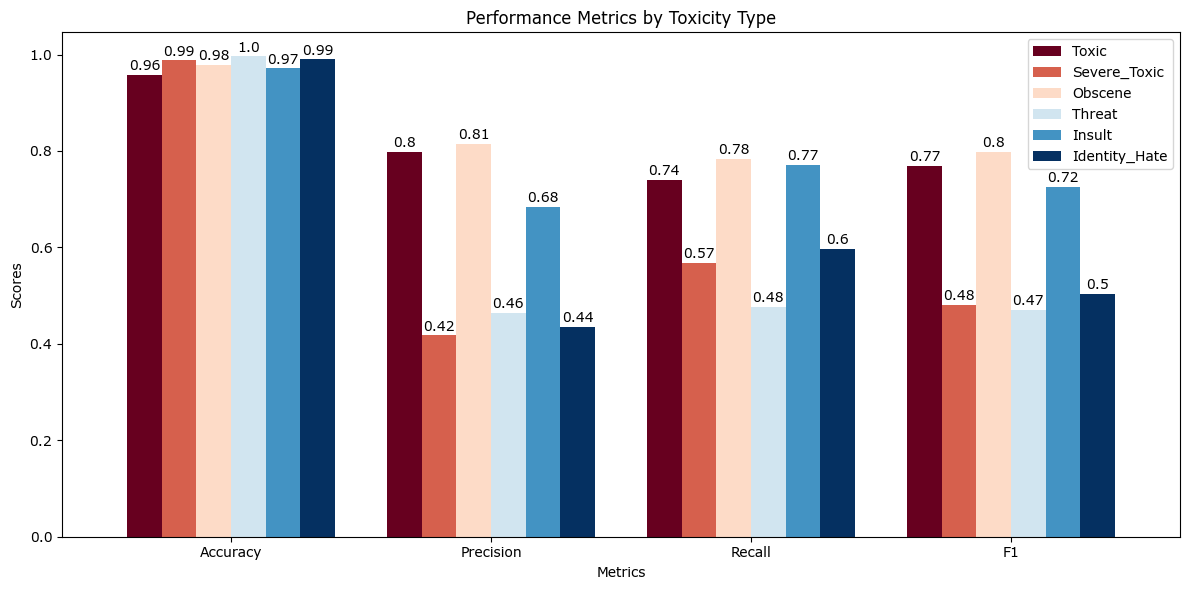

In [89]:
# Make predictions
y_pred = model_2.predict([tokens_dev], batch_size=1024, verbose=1)

# Evaluate the performance
Model_OverallPerformance(y_pred, y_dev.values, adjustThreshold=True, Thresholdplot=False)

_Compared to the DNN model, the **CNN** model **consistently improved across all toxicity subtypes**, especially in the **threat** category, where the F1 scores increased from 0.41 to 0.47._  

### 3.3 Experiment 3: CNN + LSTM

_Compared to the previous model, Model 3 combines a **convolutional layer for feature extraction** with an **LSTM layer to capture sequential dependencies** in the text.  This **hybrid appeoach** allows the model to leverage the strengths of both CNNs and LSTMs, making it better at capturing both local and sequential patterns for text classification tasks._   

In [134]:
# Build the model
model_3 = Sequential()

model_3.add(layers.Input(shape=(maxlen,)))
model_3.add(layers.Embedding(embedding_matrix.shape[0],
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix]))
model_3.add(layers.Conv1D(128, 3, activation="relu"))
model_3.add(layers.MaxPooling1D(2))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.LSTM(64, dropout=0.3))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(50, activation="relu"))
model_3.add(layers.Dropout(0.1))
model_3.add(layers.Dense(6, activation="sigmoid"))

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 48, 128)           38528     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                     

In [135]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=[f1_m])

# Model checkpoint
checkpoint = ModelCheckpoint("models/model-03-cnn-lstm.tf", 
                             monitor="val_f1_m", 
                             save_best_only=True,
                             mode="max")

# Early stopping
early_stopping = EarlyStopping(monitor="val_f1_m", 
                               patience=3, 
                               mode="max", 
                               restore_best_weights=True)

# Learning rate scheduler (optional)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", 
                                 factor=0.5, 
                                 patience=2, 
                                 min_lr=1e-6)

# Fit the model
model_3.fit(tokens_train, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/10


2024-08-30 23:27:47.514513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:27:48.019338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:27:49.270293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3192/3192 [==============================] - ETA: 0s - loss: 0.0731 - f1_m: 0.5539

2024-08-30 23:28:50.305592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:28:50.519325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


3192/3192 [==============================] - 70s 21ms/step - loss: 0.0731 - f1_m: 0.5539 - val_loss: 0.0552 - val_f1_m: 0.6059 - lr: 0.0010
Epoch 2/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0518 - f1_m: 0.6426INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


3192/3192 [==============================] - 58s 18ms/step - loss: 0.0518 - f1_m: 0.6426 - val_loss: 0.0553 - val_f1_m: 0.6241 - lr: 0.0010
Epoch 3/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0462 - f1_m: 0.6772INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


3192/3192 [==============================] - 59s 18ms/step - loss: 0.0462 - f1_m: 0.6772 - val_loss: 0.0525 - val_f1_m: 0.6412 - lr: 0.0010
Epoch 4/10
3192/3192 [==============================] - 59s 18ms/step - loss: 0.0415 - f1_m: 0.7101 - val_loss: 0.0555 - val_f1_m: 0.6281 - lr: 0.0010
Epoch 5/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0376 - f1_m: 0.7309INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


INFO:tensorflow:Assets written to: models/model-03-cnn-lstm.tf/assets


3192/3192 [==============================] - 62s 19ms/step - loss: 0.0376 - f1_m: 0.7309 - val_loss: 0.0538 - val_f1_m: 0.6756 - lr: 0.0010
Epoch 6/10
3192/3192 [==============================] - 57s 18ms/step - loss: 0.0313 - f1_m: 0.7747 - val_loss: 0.0608 - val_f1_m: 0.6564 - lr: 5.0000e-04
Epoch 7/10
3192/3192 [==============================] - 59s 18ms/step - loss: 0.0286 - f1_m: 0.7903 - val_loss: 0.0633 - val_f1_m: 0.6442 - lr: 5.0000e-04
Epoch 8/10
3192/3192 [==============================] - 62s 20ms/step - loss: 0.0251 - f1_m: 0.8238 - val_loss: 0.0678 - val_f1_m: 0.6523 - lr: 2.5000e-04


In [137]:
# Load the best model
model_3 = load_model("models/model-03-cnn-lstm.tf", custom_objects={"f1_m": f1_m})

2024-08-30 23:35:56.720421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:35:56.900042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 17ms/step


/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9596,0.9866,0.9806,0.9965,0.9712,0.9903
Precision,0.7960,0.3913,0.8454,0.4884,0.6847,0.4468
Recall,0.7685,0.6635,0.7717,0.3853,0.7611,0.5345
F1,0.7820,0.4923,0.8069,0.4308,0.7209,0.4868


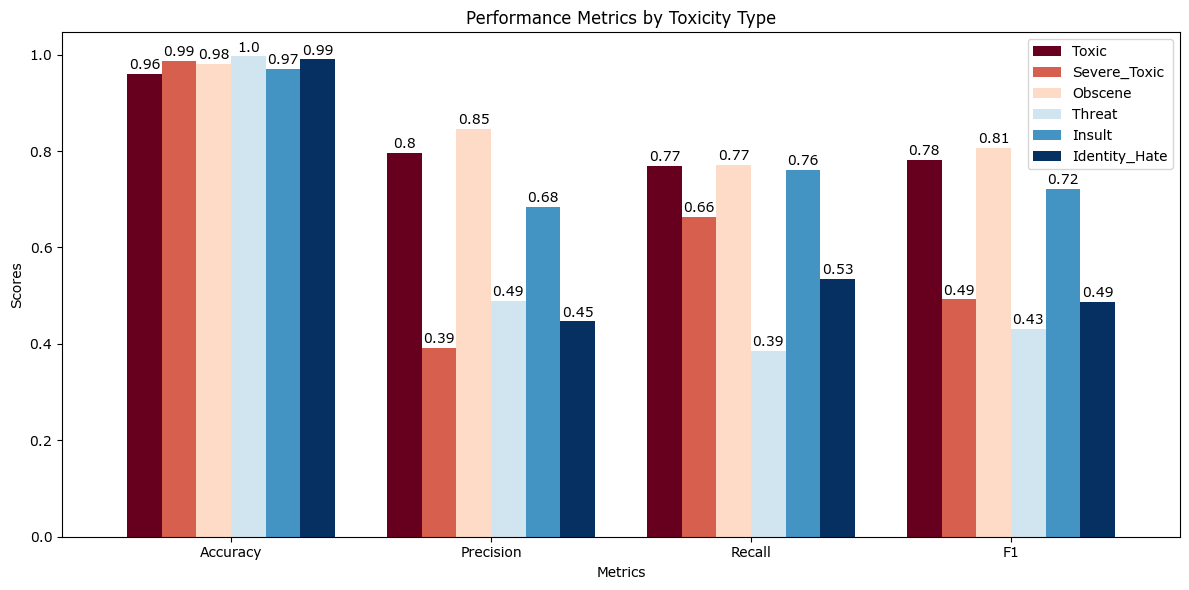

In [138]:
# Make predictions
y_pred = model_3.predict([tokens_dev], batch_size=1024, verbose=1)

# Evaluate the performance
Model_OverallPerformance(y_pred, y_dev.values, adjustThreshold=True, Thresholdplot=False)

_Despite the increasing complexity, the **CNN + LSTM** model did not show significant improvements in performance.  While the F1 score slightly **increased for toxic and severe toxic**, it slightly **decreased for all other catgeories**._  

### 3.4 Experiment 4: 1-Layer BLSTM

_Model 4 uses a **Bidirectional LSTM layer** to process sequences in **both forward and backward directions**.  This improves the model's ability to understand context by capturing dependencies in both directions, leading to improved performance as **context from both earlier and later parts of the text is crucial**._  

In [142]:
# Build the model
model_4 = Sequential([])

model_4.add(layers.Input(shape=(maxlen,)))
model_4.add(layers.Embedding(embedding_matrix.shape[0], 
                             embedding_matrix.shape[1], 
                             weights=[embedding_matrix]))
model_4.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True)))
model_4.add(layers.GlobalMaxPool1D())
model_4.add(layers.Dense(50, activation="relu"))
model_4.add(layers.Dropout(0.1))
model_4.add(layers.Dense(6, activation="sigmoid"))

model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 bidirectional (Bidirection  (None, 50, 100)           60400     
 al)                                                             
                                                                 
 global_max_pooling1d_2 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_15 (Dense)            (None, 50)                5050      
                                                                 
 dropout_16 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 6)                

In [98]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=[f1_m])

# Model checkpoint
checkpoint = ModelCheckpoint("models/model-04-blstm-1layer.tf", 
                             monitor="val_f1_m", 
                             save_best_only=True,
                             mode="max")

# Early stopping
early_stopping = EarlyStopping(monitor="val_f1_m", 
                               patience=3, 
                               mode="max", 
                               restore_best_weights=True)

# Learning rate scheduler (optional)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", 
                                 factor=0.5, 
                                 patience=2, 
                                 min_lr=1e-6)

# Fit the model
model_4.fit(tokens_train, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/10


2024-08-30 10:42:32.733357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 10:42:33.117138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 10:42:33.154374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 10:42:34.341657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 10:42:34.365270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3192/3192 [==============================] - ETA: 0s - loss: 0.0605 - f1_m: 0.5847

2024-08-30 10:44:25.534421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 10:44:25.698150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 10:44:25.715726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model-04-blstm-1layer.tf/assets


INFO:tensorflow:Assets written to: models/model-04-blstm-1layer.tf/assets


3192/3192 [==============================] - 128s 39ms/step - loss: 0.0605 - f1_m: 0.5847 - val_loss: 0.0543 - val_f1_m: 0.5698 - lr: 0.0010
Epoch 2/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0445 - f1_m: 0.6710INFO:tensorflow:Assets written to: models/model-04-blstm-1layer.tf/assets


INFO:tensorflow:Assets written to: models/model-04-blstm-1layer.tf/assets


3192/3192 [==============================] - 109s 34ms/step - loss: 0.0445 - f1_m: 0.6710 - val_loss: 0.0485 - val_f1_m: 0.6593 - lr: 0.0010
Epoch 3/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0382 - f1_m: 0.7122INFO:tensorflow:Assets written to: models/model-04-blstm-1layer.tf/assets


INFO:tensorflow:Assets written to: models/model-04-blstm-1layer.tf/assets


3192/3192 [==============================] - 111s 35ms/step - loss: 0.0382 - f1_m: 0.7122 - val_loss: 0.0485 - val_f1_m: 0.6777 - lr: 0.0010
Epoch 4/10
3192/3192 [==============================] - 105s 33ms/step - loss: 0.0328 - f1_m: 0.7511 - val_loss: 0.0524 - val_f1_m: 0.6539 - lr: 0.0010
Epoch 5/10
3192/3192 [==============================] - 104s 33ms/step - loss: 0.0256 - f1_m: 0.7996 - val_loss: 0.0579 - val_f1_m: 0.6724 - lr: 5.0000e-04
Epoch 6/10
3192/3192 [==============================] - 105s 33ms/step - loss: 0.0216 - f1_m: 0.8307 - val_loss: 0.0660 - val_f1_m: 0.6554 - lr: 5.0000e-04


In [144]:
# Load the best model
model_4 = load_model("models/model-04-blstm-1layer.tf", custom_objects={"f1_m": f1_m})

2024-08-30 23:46:14.234125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:46:14.348709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:46:14.366972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 38ms/step


/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9617,0.9877,0.9806,0.9961,0.9732,0.9922
Precision,0.8260,0.4161,0.8248,0.4462,0.7149,0.5465
Recall,0.7515,0.6282,0.7992,0.5321,0.7534,0.5345
F1,0.7870,0.5006,0.8118,0.4854,0.7336,0.5404


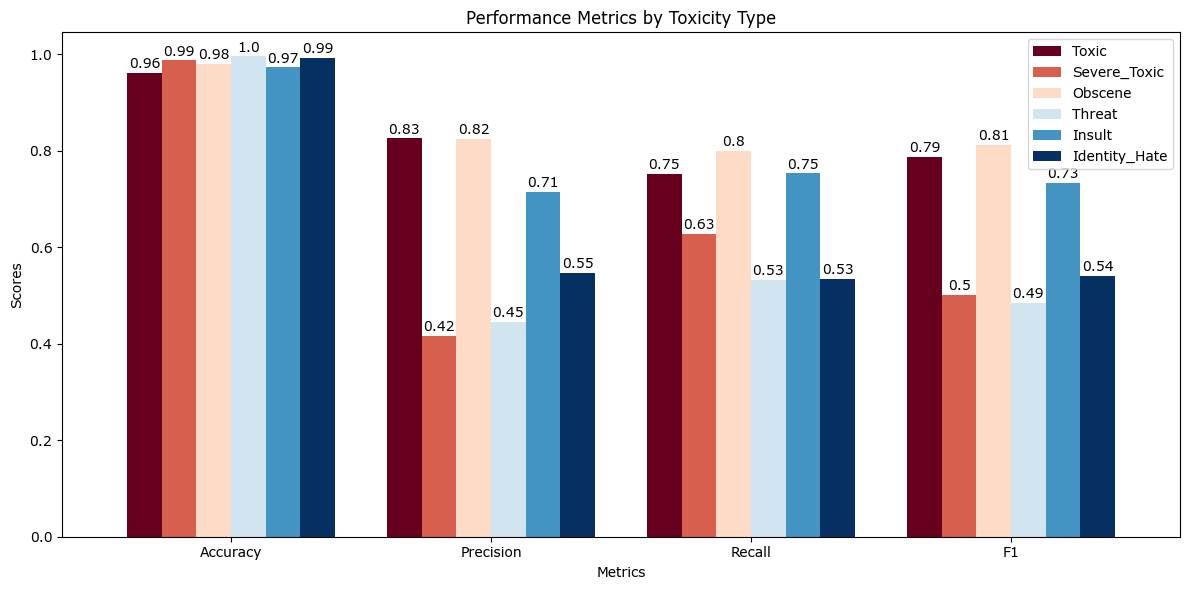

In [145]:
# Make predictions
y_pred = model_4.predict([tokens_dev], batch_size=1024, verbose=1)

# Evaluate the performance
Model_OverallPerformance(y_pred, y_dev.values, adjustThreshold=True, Thresholdplot=False)

_The **1-Layer BLSTM** outperformed all other models, achieving the **highest F1 scores across almost all toxicity subtypes**.  This suggests that the bidirectional LSTM effectively **captured contextual information in text**, leading to better classification performance._  

### 3.5 Experiment 5: 2-Layer BLSTM

_Model 5 extends Model 4 by **adding a second BLSTM layer** with dropout, which increases the model's capacity to capture more complex patterns in the data.  This **deeper architecture** allows for more nuanced understanding of text sequences, leading to **potential improvements in performance**, though it also **increases the risk of overfitting**._  

In [148]:
# Build the model
model_5 = Sequential([])

model_5.add(layers.Input(shape=(maxlen,)))
model_5.add(layers.Embedding(embedding_matrix.shape[0], 
                             embedding_matrix.shape[1], 
                             weights=[embedding_matrix]))
model_5.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3)))
model_5.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(50, activation="relu"))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.Dense(6, activation="sigmoid"))

model_5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 128)           84480     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 50)                6450      
                                                      

In [365]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=[f1_m])

# Model checkpoint
checkpoint = ModelCheckpoint("models/model-05-blstm-2layer.tf", 
                             monitor="val_f1_m", 
                             save_best_only=True,
                             mode="max")

# Early stopping
early_stopping = EarlyStopping(monitor="val_f1_m", 
                               patience=3, 
                               mode="max", 
                               restore_best_weights=True)

# Learning rate scheduler (optional)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", 
                                 factor=0.5, 
                                 patience=2, 
                                 min_lr=1e-6)

# Fit the model
model_5.fit(tokens_train, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/10


2024-08-30 17:31:28.392887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:31:30.548187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:31:30.565069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:31:32.649087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:31:32.665497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:31:38.633808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:31:38.660473: I tensorflow/core/grappler/optimizers/cust

3192/3192 [==============================] - ETA: 0s - loss: 0.0695 - f1_m: 0.5626

2024-08-30 17:35:59.188774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:35:59.901112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:35:59.912594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:36:01.206005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 17:36:01.217997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


3192/3192 [==============================] - 318s 94ms/step - loss: 0.0695 - f1_m: 0.5626 - val_loss: 0.0545 - val_f1_m: 0.6395 - lr: 0.0010
Epoch 2/10
3192/3192 [==============================] - 242s 76ms/step - loss: 0.0525 - f1_m: 0.6406 - val_loss: 0.0511 - val_f1_m: 0.6341 - lr: 0.0010
Epoch 3/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0470 - f1_m: 0.6754INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


3192/3192 [==============================] - 189s 59ms/step - loss: 0.0470 - f1_m: 0.6754 - val_loss: 0.0515 - val_f1_m: 0.6589 - lr: 0.0010
Epoch 4/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0425 - f1_m: 0.6935INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


3192/3192 [==============================] - 195s 61ms/step - loss: 0.0425 - f1_m: 0.6935 - val_loss: 0.0514 - val_f1_m: 0.6698 - lr: 0.0010
Epoch 5/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0373 - f1_m: 0.7299INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


INFO:tensorflow:Assets written to: models/model-05-blstm-2layer.tf/assets


3192/3192 [==============================] - 187s 58ms/step - loss: 0.0373 - f1_m: 0.7299 - val_loss: 0.0528 - val_f1_m: 0.6819 - lr: 5.0000e-04
Epoch 6/10
3192/3192 [==============================] - 174s 54ms/step - loss: 0.0351 - f1_m: 0.7395 - val_loss: 0.0573 - val_f1_m: 0.6707 - lr: 5.0000e-04
Epoch 7/10
3192/3192 [==============================] - 155s 49ms/step - loss: 0.0321 - f1_m: 0.7618 - val_loss: 0.0573 - val_f1_m: 0.6739 - lr: 2.5000e-04
Epoch 8/10
3192/3192 [==============================] - 173s 54ms/step - loss: 0.0306 - f1_m: 0.7711 - val_loss: 0.0581 - val_f1_m: 0.6791 - lr: 2.5000e-04


In [150]:
# Load the best model
model_5 = load_model("models/model-05-blstm-2layer.tf", custom_objects={"f1_m": f1_m})

2024-08-30 23:46:49.114562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:46:49.275926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:46:49.295787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:46:49.708724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-30 23:46:49.729596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 3s 63ms/step


/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9616,0.9859,0.9799,0.9959,0.9723,0.9904
Precision,0.8405,0.3824,0.7962,0.4198,0.7038,0.4545
Recall,0.7309,0.7244,0.8290,0.5046,0.7489,0.5455
F1,0.7819,0.5006,0.8123,0.4583,0.7256,0.4959


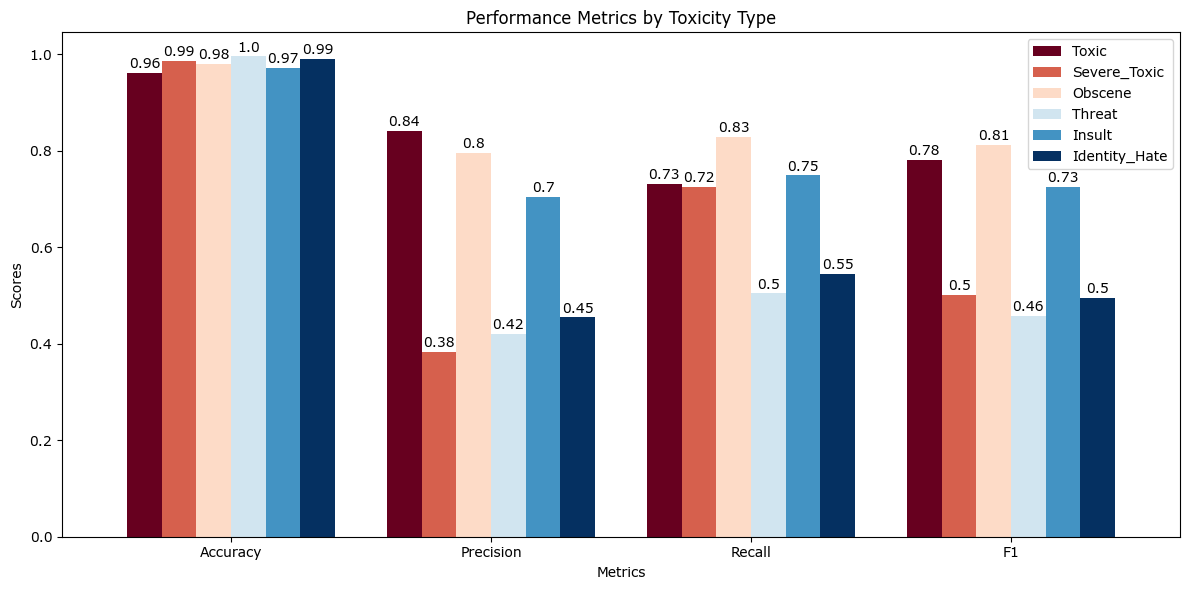

In [151]:
# Make predictions
y_pred = model_5.predict([tokens_dev], batch_size=1024, verbose=1)

# Evaluate the performance
Model_OverallPerformance(y_pred, y_dev.values, adjustThreshold=True, Thresholdplot=False)

_THe **2-Layer BLSTM** maintained strong performance, particularly in the **obscene** category with an F1 score of 0.8123, the highest among all models.  However, it showed **slightly reduced performance** in other categories compared to the 1-Layer BLSTM, indicating **potential overfitting**._  

### 3.6 Experiment 6: 3-Layer BLSTM

_Designed to capture hierarchical features in text, Model 6 **stacks 3 BLSTM layers**, though the **increased complexity** could lead to **overfitting**._  

In [162]:
# Build the model
model_6 = Sequential([])

model_6.add(layers.Input(shape=(maxlen,)))
model_6.add(layers.Embedding(embedding_matrix.shape[0], 
                             embedding_matrix.shape[1], 
                             weights=[embedding_matrix]))
model_6.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3)))
model_6.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2)))
model_6.add(layers.Bidirectional(layers.LSTM(32, dropout=0.1)))
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(50, activation="relu"))
model_6.add(layers.Dropout(0.1))
model_6.add(layers.Dense(6, activation="sigmoid"))

model_6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 100)           2000000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 128)           84480     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 50, 64)            41216     
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                    

In [163]:
# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=[f1_m])

# Model checkpoint
checkpoint = ModelCheckpoint("models/model-06-blstm-3layer.tf", 
                             monitor="val_f1_m", 
                             save_best_only=True,
                             mode="max")

# Fit the model
model_6.fit(tokens_train, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            callbacks=[checkpoint])

Epoch 1/10


2024-08-31 00:39:30.199457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:39:31.250025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:39:31.266281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:39:31.716681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:39:31.731870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:39:32.252542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:39:32.267905: I tensorflow/core/grappler/optimizers/cust

3192/3192 [==============================] - ETA: 0s - loss: 0.0717 - f1_m: 0.5491

2024-08-31 00:43:14.953270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:43:15.261314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:43:15.285848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:43:15.579315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:43:15.592338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:43:15.879095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 00:43:15.889462: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


3192/3192 [==============================] - 259s 78ms/step - loss: 0.0717 - f1_m: 0.5491 - val_loss: 0.0593 - val_f1_m: 0.6047
Epoch 2/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0526 - f1_m: 0.6441INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


3192/3192 [==============================] - 234s 73ms/step - loss: 0.0526 - f1_m: 0.6441 - val_loss: 0.0549 - val_f1_m: 0.6293
Epoch 3/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0479 - f1_m: 0.6710INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


3192/3192 [==============================] - 234s 73ms/step - loss: 0.0479 - f1_m: 0.6710 - val_loss: 0.0509 - val_f1_m: 0.6449
Epoch 4/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0438 - f1_m: 0.6889INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


3192/3192 [==============================] - 232s 73ms/step - loss: 0.0438 - f1_m: 0.6889 - val_loss: 0.0509 - val_f1_m: 0.6665
Epoch 5/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0403 - f1_m: 0.7114INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


3192/3192 [==============================] - 242s 76ms/step - loss: 0.0403 - f1_m: 0.7114 - val_loss: 0.0542 - val_f1_m: 0.6687
Epoch 6/10
3192/3192 [==============================] - 228s 71ms/step - loss: 0.0373 - f1_m: 0.7286 - val_loss: 0.0538 - val_f1_m: 0.6622
Epoch 7/10
3192/3192 [==============================] - ETA: 0s - loss: 0.0345 - f1_m: 0.7566INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


INFO:tensorflow:Assets written to: models/model-06-blstm-3layer.tf/assets


3192/3192 [==============================] - 228s 71ms/step - loss: 0.0345 - f1_m: 0.7566 - val_loss: 0.0593 - val_f1_m: 0.6696
Epoch 8/10
3192/3192 [==============================] - 211s 66ms/step - loss: 0.0323 - f1_m: 0.7615 - val_loss: 0.0601 - val_f1_m: 0.6615
Epoch 9/10
3192/3192 [==============================] - 226s 71ms/step - loss: 0.0298 - f1_m: 0.7851 - val_loss: 0.0666 - val_f1_m: 0.6679
Epoch 10/10
3192/3192 [==============================] - 220s 69ms/step - loss: 0.0281 - f1_m: 0.8011 - val_loss: 0.0717 - val_f1_m: 0.6688


In [164]:
# Load the best model
model_6 = load_model("models/model-06-blstm-3layer.tf", custom_objects={"f1_m": f1_m})

2024-08-31 01:18:07.183010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 01:18:07.464945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 01:18:07.551142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 01:18:08.855911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 01:18:09.241278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 01:18:09.724277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-31 01:18:09.736701: I tensorflow/core/grappler/optimizers/cust

32/32 [==============================] - 7s 89ms/step


/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chesie/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

,Toxic,Severe_Toxic,Obscene,Threat,Insult,Identity_Hate
Accuracy,0.9590,0.9876,0.9804,0.9956,0.9735,0.9919
Precision,0.8004,0.4110,0.8383,0.3667,0.7383,0.5395
Recall,0.7525,0.6218,0.7747,0.4037,0.7085,0.4473
F1,0.7757,0.4949,0.8052,0.3843,0.7231,0.4891


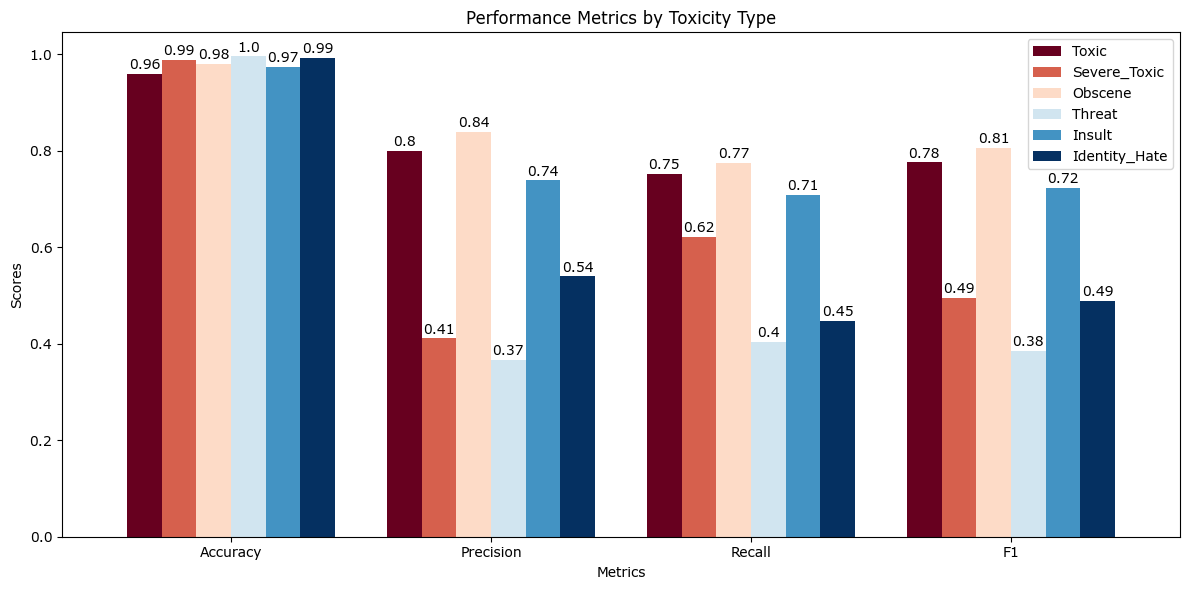

In [165]:
# Make predictions
y_pred = model_6.predict([tokens_dev], batch_size=1024, verbose=1)

# Evaluate the performance
Model_OverallPerformance(y_pred, y_dev.values, adjustThreshold=True, Thresholdplot=False)

_The **3-Layer BLSTM** showed a slight **decline in performance** compared to the 1-Layer and 2-Layer BLSTM models, particularly in the **threat** category where the **F1 score dropped to 0.38**.  This indicates that adding more layers may lead to **overfitting**, which reduces test performance._  

### 3.7 Result

_The table below summarizes the F1 scores for each subcategory across different models. The **1-layer Bidirectional LSTM model outperformed others in F1 scores across almost all toxic subtypes**, particularly in classes with severe imbalance._

In [180]:
# Define the data for each model
result = {
    "DNN": [0.7398, 0.4648, 0.7892, 0.4110, 0.6959, 0.4758],
    "CNN": [0.7684, 0.4810, 0.7988, 0.4706, 0.7249, 0.5031],
    "CNN + LSTM": [0.7820, 0.4923, 0.8069, 0.4308, 0.7209, 0.4868],
    "1-Layer BLSTM": [0.7870, 0.5006, 0.8118, 0.4854, 0.7336, 0.5404],
    "2-Layer BLSTM": [0.7819, 0.5006, 0.8123, 0.4583, 0.7256, 0.4959],
    "3-Layer BLSTM": [0.7757, 0.4949, 0.8052, 0.3843, 0.7231, 0.4891]
}

# Create a DataFrame
result = pd.DataFrame(result, index=["Toxic", "Severe_Toxic", "Obscene", 
                                   "Threat", "Insult", "Identity_Hate"])

# Display the DataFrame
result.style.highlight_max(axis=1, color="#E5E9F1")

,DNN,CNN,CNN + LSTM,1-Layer BLSTM,2-Layer BLSTM,3-Layer BLSTM
Toxic,0.739800,0.768400,0.782000,0.787000,0.781900,0.775700
Severe_Toxic,0.464800,0.481000,0.492300,0.500600,0.500600,0.494900
Obscene,0.789200,0.798800,0.806900,0.811800,0.812300,0.805200
Threat,0.411000,0.470600,0.430800,0.485400,0.458300,0.384300
Insult,0.695900,0.724900,0.720900,0.733600,0.725600,0.723100
Identity_Hate,0.475800,0.503100,0.486800,0.540400,0.495900,0.489100


_We observed several trends from the experiment:_  

_**Higher Performance in Less Imbalanced Classes**_  
_Overall, less imbalanced classes, such as toxic, obscene, and insult, achieved higher F1 scores than more imabalanced ones like severe toxic, threat, and identity hate. **Increased availability of training data** enables models to **capture class features more effectively**, which in turn **influences model performance** across the six toxic subtypes._  

_**Limitations of DNN and CNN in Contextual Understanding**_  
_DNN and CNN models demonstrated suboptimal performance in Experiments 1 and 2. Toxic language can vary in expression, from subtle sarcasm to implicit insults, with meanings often dependent on context. The **absence of natural mechanism to capture word order** makes **DNNs** less effective for such tasks. **CNNs**, although effective at identifying local patterns, may **struggle to recognize longer dependencies and contextual relationships**.  On the other hand, the **1-Layer BLSTM model** outperformed DNN and CNN, as the **birectional information flow improves its ability to understand sequential data**, capturing the nuances in natural language._    

_**Overfitting Risk with Excessive BLSTM Layers**_  
_While BLSTM models yielded better results, **adding too many layers**, as observed in Experiment 6, could result in **overfitting**. The 3-layer BLSTM model consistently underperformed the 1-layer and 2-layer BLSTM under multiple hyperparameter settings, indicating it may be **too complex for our dataset and prone to overfitting**._   